In [1]:
import Bio
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import AlignIO
import pandas as pd
import numpy as np
from jw_utils import jw_draw_tree
from plotly import graph_objects as go
import plotly.offline as pyo
from jw_utils import parse_fasta as pfa
import logomaker 
from matplotlib import pyplot as plt

In [310]:
#Align putative csrAs with muscle
!muscle -align csrA_sequences.faa -output csrA_sequences.afa


muscle 5.1.osx64 []  51.5Gb RAM, 8 cores
Built Feb 22 2022 02:38:35
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 557 seqs, avg length 74, max 99

00:00 19Mb   CPU has 8 cores, running 8 threads
00:26 795Mb   100.0% Calc posteriors  
02:48 1.6Gb   100.0% Consistency (1/2)  2)0:35 842Mb     6.1% Consistency (1/2))/2)
05:10 1.6Gb   100.0% Consistency (2/2)  4:22 1.6Gb    71.7% Consistency (2/2)/2)/2)
05:10 1.6Gb   100.0% UPGMA5           
05:23 1.6Gb   100.0% Refining


In [4]:
def rm_gaps(threshold, fasta_alignment):
    
    ## throw out gaps at threshold in alignment
    aln_dict = pfa.get_seq_dict(fasta_alignment)
    aln_d_sep = {}
    #seperate the sequence string into a list for a dataframe
    for key, val in aln_dict.items():
        aln_d_sep[key] = list(val)
    df = pd.DataFrame(aln_d_sep.values(), aln_d_sep.keys())
    threshold = threshold
    cols_to_keep = []
    for col in df:
        filt = (df[col] == '-') 
        perc_gap = filt.sum()/filt.shape[0]
        if perc_gap <= threshold:
            cols_to_keep.append(col) 
    df = df[cols_to_keep]
    aln_dict ={}
    for seq in df.index:
          aln_dict[seq] = ''.join(df.loc[seq,:])
    return aln_dict

fasta_alignment = 'csrA_sequences.afa'

aln_dict = rm_gaps(0.99, fasta_alignment)
pfa.write_to_fasta(aln_dict,'csrA_sequences_trimmed_99.afa' )

In [4]:
#create distance matrix from pre - existing alignment
aln = AlignIO.read(open('csrA_sequences_trimmed_99.afa'), 'fasta')
calculator = DistanceCalculator('blosum62')
dm = calculator.get_distance(aln)
csra_nj_tree = DistanceTreeConstructor().nj(dm)

In [3]:
#Phylo.write(csra_nj_tree,'csrA_trimmed99_njtree.nwk', format='newick')
csra_nj_tree = Phylo.read('csrA_trimmed99_njtree.nwk', "newick")
fig = jw_draw_tree.create_plotly_tree_t(csra_nj_tree, height=1500)
go.Figure(fig)
pyo.plot(fig)

this was triggered


'temp-plot.html'

In [153]:
# Pick clades to get representative sequence for
clade_names = ['Inner531', 'Inner524', 'Inner535', 'Inner539', 'Inner521', 'Inner541',
               'Inner552', 'Inner551','Inner550', 'Inner545']

colors = [ 'rgba(144,174,178,1)','rgba(0,250,250,1)','rgba(238,230,222,1)',
          'rgba(55,81,77,1)','rgba(100,121,124,1)', 'rgba(250,250,0,1)',
          'rgba(250,0,0,1)','rgba(190,132,94,1)','rgba(0,250,0,1) ',
          'rgba(0,0,250,1)','rgba(182,89,76,1)']

for name in clade_names:
    non_term_namelst = [cl.name for cl in csra_nj_tree.get_nonterminals()]
    if name not in non_term_namelst:
        print(name)


In [79]:
# get terminals of each clade
non_term_clades = {cl.name:cl for cl in csra_nj_tree.get_nonterminals()}
clade_leaves = {}
clade_colors = {}
for clade, color in zip(clade_names, colors):
    clade_leaves[clade] = [cl.name for cl in non_term_clades.get(clade).get_terminals()]
    clade_colors[color] = [cl.name for cl in non_term_clades.get(clade).get_terminals()]

In [80]:
fig = jw_draw_tree.create_plotly_tree(csra_nj_tree,t_nodes_color_dict=clade_colors, height=1500)
fig = go.Figure(fig)
pyo.plot(fig)
fig.write_html('./clusters_njTree.html')

'temp-plot.html'

In [ ]:
def get_interenal_clade_objects(clade_names):
    "Return list of internal node objects from a list of node names"
    clades_of_interest = []
    for clade in csra_nj_tree.get_nonterminals():
        if clade.name in clade_names:
            clades_of_interest.append(clade)
            print(f'name: {clade.name} branch length: {clade.total_branch_length()}')
    return clades_of_interest

#pull alignments from afa file
def subset_of_alignments(lst_of_names, path_to_afa):
    "return a dict with subset of alignments from .afa file"
    
    subset_dict = {}
    seq_dict = pfa.get_seq_dict(path_to_afa)
    for name in lst_of_names:
        if seq_dict.get(name):  
            subset_dict[name] = seq_dict[name]
        else:
            print(f'{name} was not found')
    return subset_dict


def get_nested_algn_dict_from_clades(clade_names, path_to_afa):
    """return a dict for each clade with all alignments.
    
    parameters:
    clade_names (list): list of internal tree node names
    path_to_afa (str): path to fasta alignment
    
    return (dict): {clade_name:{seq_name:aligned_seq}}
    """
    
    clades_of_interest = get_interenal_clade_objects(clade_names)
    clades_dict = {}
    d_of_subset_ds = {}
    for clade in clades_of_interest:
        clades_dict[clade.name] = [cl.name for cl in clade.get_terminals()]
        subset_dict = subset_of_alignments(clades_dict[clade.name], path_to_afa)
        d_of_subset_ds[clade.name] = subset_dict
    return d_of_subset_ds
d_of_subset_ds = get_nested_algn_dict_from_clades(clade_names, 'csrA_sequences_trimmed_99.afa' )  

In [159]:
clade_names = ['Inner531', 'Inner524', 'Inner535', 'Inner539', 'Inner521', 'Inner541',
               'Inner552', 'Inner551','Inner550', 'Inner545']

colors = [ 'rgba(144,174,178,1)','rgba(0,250,250,1)','rgba(238,230,222,1)',
          'rgba(55,81,77,1)','rgba(100,121,124,1)', 'rgba(250,250,0,1)',
          'rgba(250,0,0,1)','rgba(190,132,94,1)','rgba(0,250,0,1) ',
          'rgba(0,0,250,1)','rgba(182,89,76,1)']

clade_color_d = {clade:color for clade, color in zip(clade_names, colors)}
    


d_of_subset_ds
with open('./clusters.tsv' , 'w') as f:
    f.write('clade\tseq_id\tcolor\n')
    for clade in d_of_subset_ds.keys():
        for seq_id in d_of_subset_ds[clade]:
            f.write(f'{clade}\t{seq_id}\t{clade_color_d[clade]}\n')

In [83]:
def make_logomatrix_for_each_cluster(d_of_subset_ds):
    
    mat_dict = {}
    for cluster, aligments_d in d_of_subset_ds.items():
        mat_dict[cluster] = logomaker.alignment_to_matrix(list(aligments_d.values()), to_type='information')
    return mat_dict

mat_dict = make_logomatrix_for_each_cluster(d_of_subset_ds)

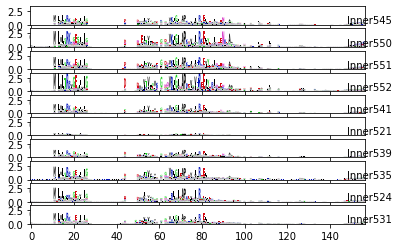

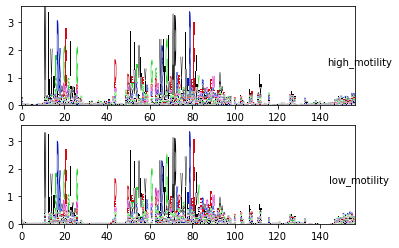

In [160]:
def plot_each_cluster_logo(mat_dict, colors = None):
    color_schemes_df = logomaker.list_color_schemes()
    ncols = 1
    nrows = len(mat_dict)
    fig, axs = plt.subplots(nrows, ncols)
    #find max yval
    max_yval = 0
    for c in mat_dict.keys():
        if mat_dict[c].sum(axis=1).max()>max_yval:
            max_yval=mat_dict[c].sum(axis=1).max()
    #build axes in fig
    for i, cluster in enumerate(mat_dict.keys()):
        logomaker.Logo(mat_dict[cluster],
                      ax=axs[i],
                      color_scheme = color_schemes_df.loc[4, 'color_scheme'] )
        if i != nrows-1:
            axs[i].set_xlabel(None)
        axs[i].set_ylim([0,max_yval])
        axs[i].set_ylabel(cluster, rotation=0)
        axs[i].yaxis.set_label_position("right")
#         if colors:
#             axs[i].yaxis.label.set_color(colors[i])
#             axs[i].spines.set_color(colors[i])
#             print(f'cluster: {cluster} color: c{colors[i]}')
            
        
    return fig
cl_logo_fig = plot_each_cluster_logo(mat_dict, colors = colors)
cl_logo_fig.savefig('cluster_logos.pdf')  

In [183]:
## 
def filt_df(path_to_scores, mot_thresh_high = 1.7, mot_threshold_low = 0.2):
    d = {}
    mot_scores_df = pd.read_csv(path_to_scores)
    mot_scores_df = mot_scores_df.dropna()
    d['high_motility'] = mot_scores_df.loc[mot_scores_df['mot_mean']>mot_thresh_high,:]
    d['low_motility'] = mot_scores_df.loc[mot_scores_df['mot_mean']<=mot_threshold_low,:]
    return d
motility_df_dict = filt_df(path_to_scores='motility_scores.csv', 
                           mot_thresh_high = 0.7, mot_threshold_low = 0.7)

In [184]:
mot_colors ={'high_motility':'magenta', 'low_motility':'cyan'}
color_mot_dict = {mot_colors[val]:list(motility_df_dict[val]['reference']) for val in motility_df_dict}


In [185]:
fig = jw_draw_tree.create_plotly_tree(csra_nj_tree,t_nodes_color_dict=color_mot_dict, height=1500)
fig = go.Figure(fig)
pyo.plot(fig)
fig.write_html('./motility_njTree.html')


In [100]:
trimmed_algnment_d = pfa.get_seq_dict('csrA_sequences_trimmed_99.afa')
motility_algn = {}
high_motility_algn = {}
for value, df in motility_df_dict.items():
    motility_algn[value]=[]
    for seq_id in motility_df_dict[value]['reference']:
        motility_algn[value].append(trimmed_algnment_d[seq_id])



In [102]:
motility_matrices_d = {}
for value, aligned_seqs in motility_algn.items():
    motility_matrices_d[value] = logomaker.alignment_to_matrix(list(aligned_seqs), to_type='information')


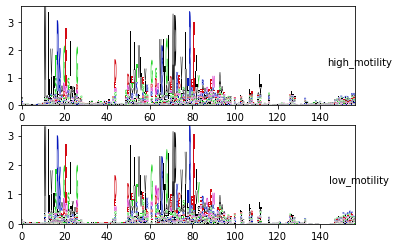

In [103]:
fig = plot_each_cluster_logo(motility_matrices_d)
fig.savefig('mot_logos.pdf')